<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Experiment-description" data-toc-modified-id="Experiment-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Experiment description</a></span></li><li><span><a href="#Code-definitions-and-initializations" data-toc-modified-id="Code-definitions-and-initializations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Code definitions and initializations</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Database-initialization-and-loading-experiment" data-toc-modified-id="Database-initialization-and-loading-experiment-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Database initialization and loading experiment</a></span></li></ul></li><li><span><a href="#Code-of-the-experiment" data-toc-modified-id="Code-of-the-experiment-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Code of the experiment</a></span><ul class="toc-item"><li><span><a href="#Create-AWG-signal" data-toc-modified-id="Create-AWG-signal-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create AWG signal</a></span></li><li><span><a href="#Hook-up-AWG-and-lock-in's-in-a-class" data-toc-modified-id="Hook-up-AWG-and-lock-in's-in-a-class-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Hook up AWG and lock-in's in a class</a></span></li><li><span><a href="#Setup-a-station" data-toc-modified-id="Setup-a-station-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Setup a station</a></span></li><li><span><a href="#Define-a-meta-instrument-with-measurable/interesting-paramters" data-toc-modified-id="Define-a-meta-instrument-with-measurable/interesting-paramters-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Define a meta-instrument with measurable/interesting paramters</a></span></li><li><span><a href="#Set-up-lock-in's-for-the-measurement" data-toc-modified-id="Set-up-lock-in's-for-the-measurement-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Set up lock-in's for the measurement</a></span><ul class="toc-item"><li><span><a href="#Main-lock-in" data-toc-modified-id="Main-lock-in-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Main lock-in</a></span></li><li><span><a href="#Lock-in-2" data-toc-modified-id="Lock-in-2-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>Lock-in 2</a></span></li><li><span><a href="#Lock-in-3" data-toc-modified-id="Lock-in-3-3.5.3"><span class="toc-item-num">3.5.3&nbsp;&nbsp;</span>Lock-in 3</a></span></li></ul></li><li><span><a href="#Empty-cell-for-playing-with-objects" data-toc-modified-id="Empty-cell-for-playing-with-objects-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Empty cell for playing with objects</a></span></li><li><span><a href="#Run-measurement-and-get-data" data-toc-modified-id="Run-measurement-and-get-data-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Run measurement and get data</a></span></li><li><span><a href="#Plot-all-acquired-data-(from-database)" data-toc-modified-id="Plot-all-acquired-data-(from-database)-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Plot all acquired data (from database)</a></span></li><li><span><a href="#Plot-all-acquired-data-(from-memory)" data-toc-modified-id="Plot-all-acquired-data-(from-memory)-3.9"><span class="toc-item-num">3.9&nbsp;&nbsp;</span>Plot all acquired data (from memory)</a></span></li><li><span><a href="#Average-acquired-data-for-accuracy" data-toc-modified-id="Average-acquired-data-for-accuracy-3.10"><span class="toc-item-num">3.10&nbsp;&nbsp;</span>Average acquired data for accuracy</a></span></li></ul></li><li><span><a href="#Miscellaneous" data-toc-modified-id="Miscellaneous-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Miscellaneous</a></span><ul class="toc-item"><li><span><a href="#A-helper-measurement-that-collects-MANY-samples-starting-from-a-trigger" data-toc-modified-id="A-helper-measurement-that-collects-MANY-samples-starting-from-a-trigger-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>A helper measurement that collects MANY samples starting from a trigger</a></span></li></ul></li></ul></div>

# Experiment description

There are two staircase ramps: a fast one, V_x, and slower one, V_y. Marker signals (a.k.a. triggers) are used within each step of the fast ramp in order to trigger the lock-in amplifier to perform a measurement of a single data point.

For the sake of accuracy, the fast staircase ramp is repeated, and the average of the acquired data points is calculated (per step of the staircase, of course).

In total, this will probably be an interesting combination of a hardware sweep, the fast staircase ramp, and a software sweep, the slow staircase ramp.

The goal of this exercise is to develop a vision on how such experiments/measurements can be neatly defined in software through QCoDeS.

---

*Note that for now the slow staircase ramp is not implemented.*

The device under test is a simple transistor - for simplicity. It's gate is set to different values of the fast staircase ramp. The drain is modulated by the lock-ins internal sine wave generator, and source is plugged as an input to the lock-in.

AWG's channel is used to define the fast staircase ramp. It's marker channel is used to trigger the lock-in amplifier to measure a sample (lock-in does it on the falling edge of the trigger). The "high" voltage of the marker is set to a big value, otherwise lock-in might not react in a robust manner.

The AWG signal output is quite limited (up to ~1Vp-p), hence the transistor won't react significantly on the fast ramp. In order to fix this, a pre-amplifier is used to multiply the AWG signal by 10x.

# Code definitions and initializations

## Imports

In [1]:
%matplotlib notebook

from hwsweep import \
    instrument_factory, init_or_create_database, load_or_create_experiment, \
    add_parameter_to_instrument, \
    RepeatingStaircaseRampGenerator, \
    OneChannelOneMarkerAwgSequencer, \
    DelegateParameter, \
    HardwareSweep, AwgSequencer

# Useful tools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from typing import Union, List, Type
from scipy.signal import savgol_filter
import time

# qcodes features
import qcodes
from qcodes import Instrument
from qcodes.dataset.database import initialise_database # needed for work with 
                                                        # a separate database during development of this scripts
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.utils.validators import Numbers
    
# Drivers
from qcodes.instrument_drivers.tektronix.AWG5208 import AWG5208
from qcodes.instrument_drivers.stanford_research.SR860 import SR860
from qcodes.instrument_drivers.stanford_research.SR86x import SR86x

# Broadbean module for defining signals emitted by AWG
import broadbean as bb
from broadbean import plotting

## Database initialization and loading experiment

In [2]:
init_or_create_database(
    r'E:\Code\lock_in_hardware_sweep_experiments.db')

experiment = load_or_create_experiment(
    experiment_name='lock_in_hardware_sweep',
    sample_name='transistor')

# Code of the experiment

## Create AWG signal

<IPython.core.display.Javascript object>


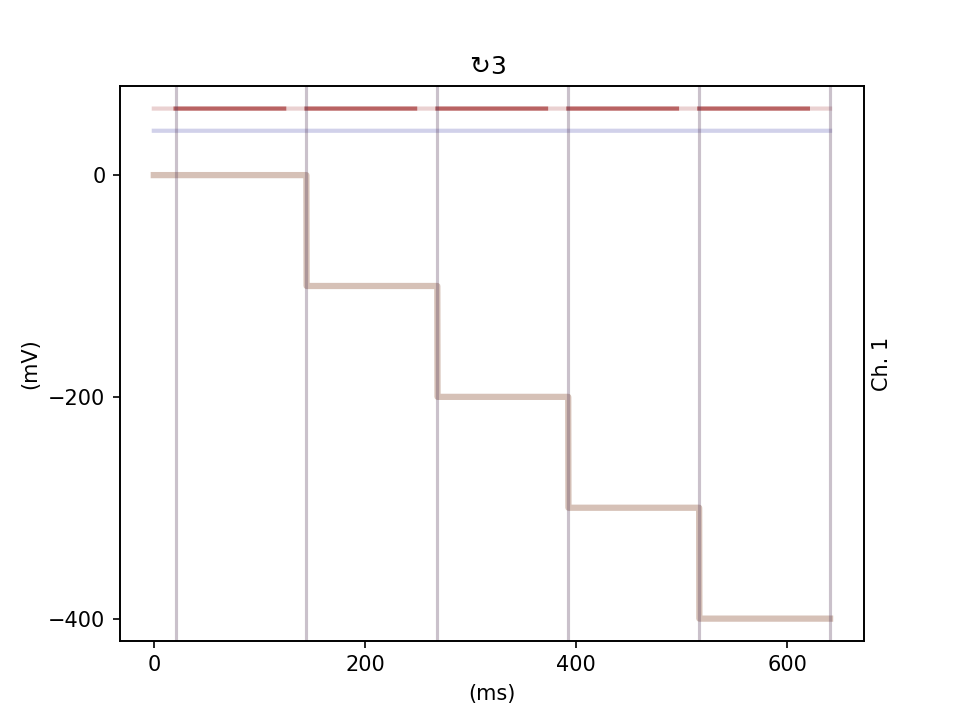

In [3]:
fast_ramp = instrument_factory(RepeatingStaircaseRampGenerator, 'fast_staircase_ramp')

fast_ramp.sample_rate(10e3)
fast_ramp.start_ramp_voltage(0)
fast_ramp.finish_ramp_voltage(-0.4)
fast_ramp.n_steps(5)  # 30
fast_ramp.n_repetitions(3)  # 20
fast_ramp.settlement_time(0.103)  # 0.103
fast_ramp.lockin_integration_time(0.021)  # 0.021
fast_ramp.restart_compensation(0.2 * fast_ramp.settlement_time())

# Convenient vectors for plotting
time_axis_points = fast_ramp.get_trigger_moments_vector()
gate_voltage_points = fast_ramp.values_vector()

# Sanity check :)
fast_ramp.plot_broadbean_sequence()

## Hook up AWG and lock-in's in a class

In [4]:
class AwgLockInVoltageRampSweep(HardwareSweep):
    """
    ...
    
    TL;DR
    AWG triggers data acquisition at 3 lock-in amplifiers.
    """
    def __init__(self,
                 name: str,
                 awg_sequencer_obj: Type[AwgSequencer],
                 lockin1: Type[SR86x],
                 lockin2: Type[SR86x],
                 lockin3: Type[SR86x],
                 **kwargs):
        super().__init__(name, **kwargs)

        self.add_submodule(name='lockin1',
                           submodule=lockin1)
        self.add_submodule(name='lockin2',
                           submodule=lockin2)
        self.add_submodule(name='lockin3',
                           submodule=lockin3)
        
        self._lockins = [self.lockin1, self.lockin2, self.lockin3]

        self.add_submodule(name='awg_sequencer',
                           submodule=awg_sequencer_obj)

        self.delegate_attr_objects = ['awg_sequencer']

        self.add_parameter('measured_voltage_at_triggers_lockin_1',
                           DelegateParameter,
                           source=self.lockin1.buffer.X,
                           label='Voltage output of lock-in amplifier 1 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 1 amplifier"
                           )
        self.add_parameter('measured_voltage_at_triggers_lockin_2',
                           DelegateParameter,
                           source=self.lockin2.buffer.X,
                           label='Voltage output of lock-in amplifier 2 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 2 amplifier"
                           )
        self.add_parameter('measured_voltage_at_triggers_lockin_3',
                           DelegateParameter,
                           source=self.lockin3.buffer.X,
                           label='Voltage output of lock-in amplifier 3 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 3 amplifier"
                           )

        self._setup_lockins()
        
    @property
    def lockins(self):
        return self._lockins
       
    def _setup_lockins(self):
        self._capture_variable_name = "X"
        
        for lockin in self.lockins:
            lockin.input_config('a')  # within "voltage" block
            
            lockin.buffer.capture_config(self._capture_variable_name)
            
            lockin.reference_source("EXT")
            
            lockin.external_reference_trigger("SIN")
            lockin.external_reference_trigger_input_resistance("1M")

    def measure_voltage_at_awg_triggers(self):
        try:
            trigger_count = self.awg_sequencer.sequence_gen.n_all_steps()
            
            for lockin in self.lockins:
                lockin.buffer.set_capture_length_to_fit_samples(trigger_count)
                lockin.buffer.start_capture("ONE", "SAMP")
            
            self.awg_sequencer.awg.play()
            
            for lockin in self.lockins:
                lockin.buffer.wait_until_samples_captured(trigger_count)
                lockin.buffer.stop_capture()
                lockin.buffer.get_capture_data(trigger_count)  # this loads data from buffer 
                                                        # to driver's "buffer readout" fields in memory
            
#             voltage_axis_points_dict = {}
#             for lockin in self.lockins:
#                 lockin_data = lockin.buffer.get_capture_data(trigger_count)
#                 voltage_axis_points_dict[lockin.name] = lockin_data[self._capture_variable_name]
                
        finally:
            self.awg_sequencer.awg.stop()
            
#         return voltage_axis_points_dict

## Setup a station

In [5]:
# Station 
#     <- AwgLockInVoltageRampSweep (HardSweep)
#            connects the signal source (AWG) with detector (lock-in),
#            and implements "hardware" measurement organization between the devices
#         <- SR860 (lock-in)
#                physical instrument
#         <- OneChannelOneMarkerAwgSequencer (AwgSequencer)
#                connects "ramp generators" with AWG instruments through broadbean
#             <- AWG5208 (awg)
#                    physical instrument
#             <- RepeatingStaircaseRampGenerator (fast_ramp)
#                    defines the fast ramp
#     <- transistor_characterizer
#            meta instrument with "meaningful" parameters
#
station = qcodes.Station()

awg = instrument_factory(
    AWG5208, "awg", address='TCPIP0::169.254.254.84::inst0::INSTR')

awg_sequencer = instrument_factory(
    OneChannelOneMarkerAwgSequencer, 'awg_sequencer', awg, fast_ramp)

# Sanity check :)
awg_sequencer.send_sequence_and_setup_awg()

lockin1 = instrument_factory(
    SR860, "lockin1", address='GPIB0::4::INSTR')
lockin2 = instrument_factory(
    SR860, "lockin2", address='GPIB0::5::INSTR')
lockin3 = instrument_factory(
    SR860, "lockin3", address='GPIB0::6::INSTR')

hwsweeper = instrument_factory(
    AwgLockInVoltageRampSweep, 'hwsweeper', awg_sequencer, lockin1, lockin2, lockin3)

station.add_component(hwsweeper)

Connected to: TEKTRONIX AWG5208 (serial:B020205, firmware:FV:6.0.0242.0) in 0.24s
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Connected to: Stanford_Research_Systems SR860 (serial:003230, firmware:V1.47) in 0.09s
Connected to: Stanford_Research_Systems SR860 (serial:003103, firmware:V1.47) in 0.05s
Connected to: Stanford_Research_Systems SR860 (serial:003101, firmware:V1.47) in 0.06s


'hwsweeper'

## Define a meta-instrument with measurable/interesting paramters

In [7]:
# This class is actually Wolfgang's HardSweepDetector.
transistor_characterizer = instrument_factory(
    Instrument, "transistor_characterizer")

# Define parameters
v_g_param = DelegateParameter(
    'v_g', 
    fast_ramp.values_with_repetitions_vector, 
    label='Gate voltage', 
    unit='V'
)
add_parameter_to_instrument(v_g_param, transistor_characterizer)

i_avg_param = DelegateParameter(
    'i_avg',
    fast_ramp.all_repetitions_vector,
    label='Index of gate voltage averaging',
    unit='#'
)
add_parameter_to_instrument(i_avg_param, transistor_characterizer)

v_sd_1_param = DelegateParameter(
    'v_sd_1',
    hwsweeper.measured_voltage_at_triggers_lockin_1,
    label='Source-drain current 1 (as voltage)',
    unit='V'
)
add_parameter_to_instrument(v_sd_1_param, transistor_characterizer)

v_sd_2_param = DelegateParameter(
    'v_sd_2',
    hwsweeper.measured_voltage_at_triggers_lockin_2,
    label='Source-drain current 2 (as voltage)',
    unit='V'
)
add_parameter_to_instrument(v_sd_2_param, transistor_characterizer)

v_sd_3_param = DelegateParameter(
    'v_sd_3',
    hwsweeper.measured_voltage_at_triggers_lockin_3,
    label='Source-drain current 3 (as voltage)',
    unit='V'
)
add_parameter_to_instrument(v_sd_3_param, transistor_characterizer)

v_slow_param = qcodes.Parameter(
    'v_slow',
    label='Slow ramp voltage', 
    unit='V'
)
add_parameter_to_instrument(v_g_param, transistor_characterizer)

station.add_component(transistor_characterizer)

Connected to: None transistor_characterizer (serial:None, firmware:None) in 6.53s


'transistor_characterizer'

## Set up lock-in's for the measurement

### Main lock-in

In [8]:
lockin1.reference_source("INT")

# Amplitude is high so that the other two lock-in's detect the reference signal
# The device under measurement is secured with a 16kOhm resister
lockin1.amplitude(1)  # [V]
lockin1.sensitivity(1)  # [V]
lockin1.input_range(300e-3)  # [V]

lockin1.adv_filter('ON') # use Gaussian filter (taking into accound our time constants range)
                        # for better filtering instead of RC
lockin1.sync_filter('ON') # also filter out lockin reference frequency harmonics

# these parameters have the most impact on the data quality
lockin1.time_constant(10e-3)  # [s]
lockin1.filter_slope(24)  # [dB]
lockin1.frequency(27.3765)  # [Hz]

### Lock-in 2

In [9]:
lockin2.sensitivity(lockin1.sensitivity())  # [V]
lockin2.input_range(lockin1.input_range())  # [V]

lockin2.adv_filter(lockin1.adv_filter())
lockin2.sync_filter(lockin1.sync_filter())

# these parameters have the most impact on the data quality
lockin2.time_constant(lockin1.time_constant())  # [s]
lockin2.filter_slope(lockin1.filter_slope())  # [dB]
lockin2.frequency(lockin1.frequency())  # [Hz]

### Lock-in 3

In [10]:
lockin3.sensitivity(lockin1.sensitivity())  # [V]
lockin3.input_range(lockin1.input_range())  # [V]

lockin3.adv_filter(lockin1.adv_filter())
lockin3.sync_filter(lockin1.sync_filter())

# these parameters have the most impact on the data quality
lockin3.time_constant(lockin1.time_constant())  # [s]
lockin3.filter_slope(lockin1.filter_slope())  # [dB]
lockin3.frequency(lockin1.frequency())  # [Hz]

## Empty cell for playing with objects

## Run measurement and get data
A special function has been implemented in the buffer of the lock-in amplifier. This function arms the lock-in so that it is ready to capture 1 sample per trigger signal, then it calls the given callable function that launches the pulse train of the triggers, waits until the requested number of samples is acquired to the buffer, and retrieves the data from the buffer.

Note that it is convenient to stop the AWG sequence from running, it does not stop itself after the sequence end is reached.

Mikhail: while playing with this setup in order to achieve data that has reasonable accuracy, I found myself adjusting lockin's time constant, lockin's reference signal frequency, and sample rate, settle time, lockin integration time variables. Perhaps, these variables should be the main parameters of this meta instrument.

In [14]:
measurement = Measurement(experiment, station)
# measurement.write_period = 2

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(v_slow_param)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, v_slow_param))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, v_slow_param))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, v_slow_param))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())

# Perform the experiment and save acquired data
with measurement.run() as data_saver:
    
    for slow_ramp in np.linspace(10, 20, 2):
    
        # The "hardware sweep"
        hwsweeper.measure_voltage_at_awg_triggers()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields

        # Save data
        t = time.time()
        data_saver.add_result(
            (v_slow_param, slow_ramp),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, source_drain_voltage_1_points),
            (v_sd_2_param, source_drain_voltage_2_points),
            (v_sd_3_param, source_drain_voltage_3_points),
        )
    
t = time.time() - t

# Convenient to have for plotting
run_id_of_data = data_saver.run_id

print(f"Data saved within {t} seconds")

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 62
Data saved within 0.13749456405639648 seconds


## Plot all acquired data (from database)

In [15]:
ax, cbax = plot_by_id(run_id_of_data)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AttributeError: 'dict' object has no attribute 'name'

## Plot all acquired data (from memory)

<IPython.core.display.Javascript object>


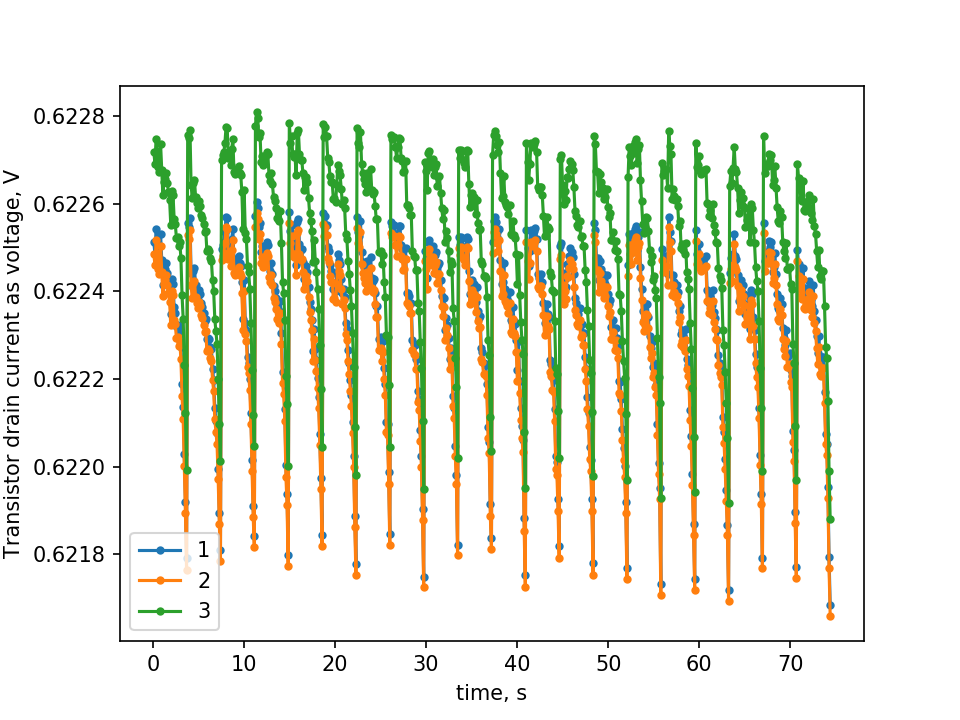

Text(0,0.5,'Transistor drain current as voltage, V')

In [12]:
plt.figure()
plt.plot(time_axis_points, source_drain_voltage_1_points, '.-', label='1')
plt.plot(time_axis_points, source_drain_voltage_2_points, '.-', label='2')
plt.plot(time_axis_points, source_drain_voltage_3_points, '.-', label='3')
plt.legend()
plt.xlabel('time, s')
plt.ylabel('Transistor drain current as voltage, V')

## Average acquired data for accuracy
This is an example of data post-processing for which this "hard sweep" is being designed for.

First let's plot source-drain current values averaged over the number of executed sequences.

<IPython.core.display.Javascript object>


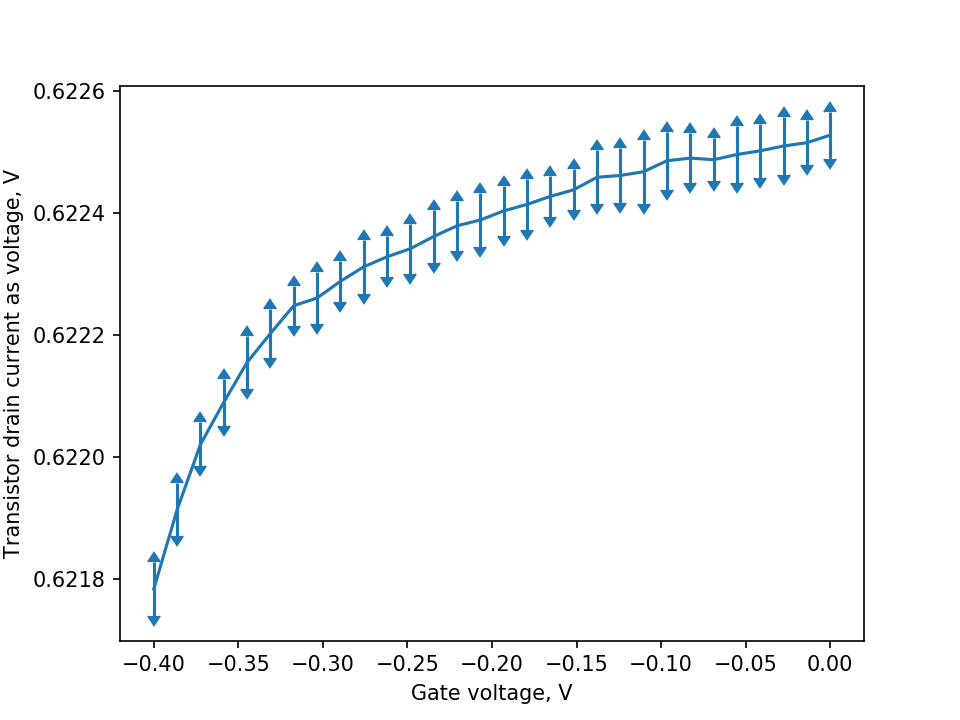

Text(0,0.5,'Transistor drain current as voltage, V')

In [13]:
source_drain_voltage_points = source_drain_voltage_1_points

voltages_matrix = source_drain_voltage_points.reshape((fast_ramp.n_repetitions(), fast_ramp.n_steps()))
averaged_voltage_points = voltages_matrix.mean(0)
averaged_voltage_points_error = voltages_matrix.std(0)

fig, ax = plt.subplots()
ax.errorbar(gate_voltage_points, averaged_voltage_points, yerr=averaged_voltage_points_error,
            lolims=True, uplims=True)

plt.xlabel('Gate voltage, V')
plt.ylabel('Transistor drain current as voltage, V')

Now let's make a more explicit plot of SNR where signal is the source-drain current, and noise is the STD of it.

<IPython.core.display.Javascript object>


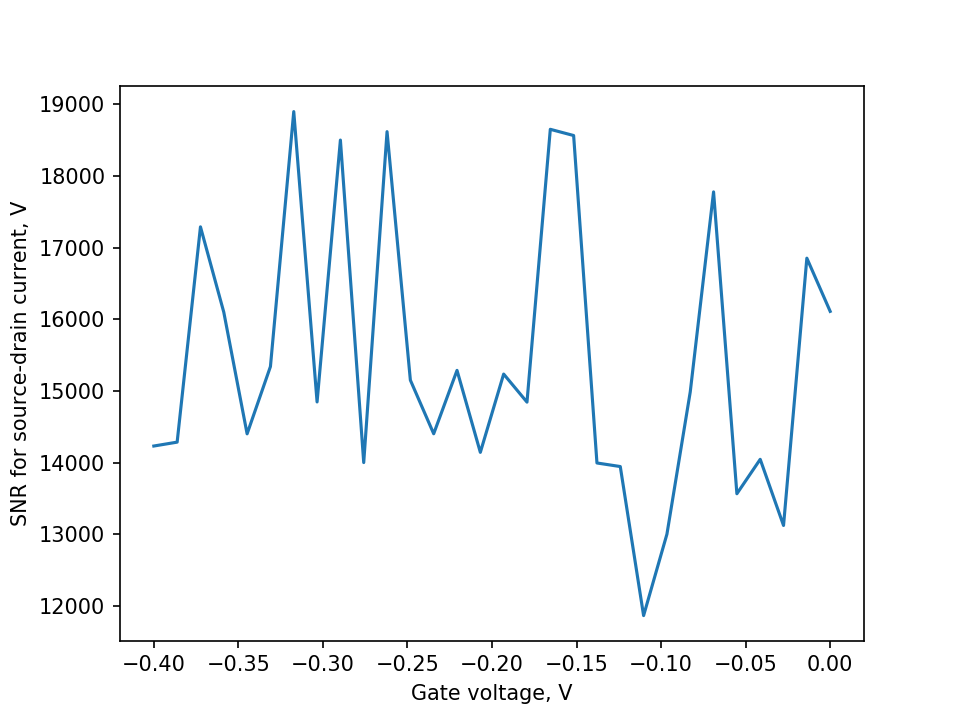

Text(0,0.5,'SNR for source-drain current, V')

In [14]:
averaged_voltage_SNR = averaged_voltage_points / averaged_voltage_points_error

fig, ax = plt.subplots()
plt.plot(gate_voltage_points, averaged_voltage_SNR)

plt.xlabel('Gate voltage, V')
plt.ylabel('SNR for source-drain current, V')

Now let's plot the behavior of standard deviation of the source-drain current with respect to the number of averages (i.e. number of repetitions). There is a line for each gate voltage, which we plot in different colors. 

<IPython.core.display.Javascript object>


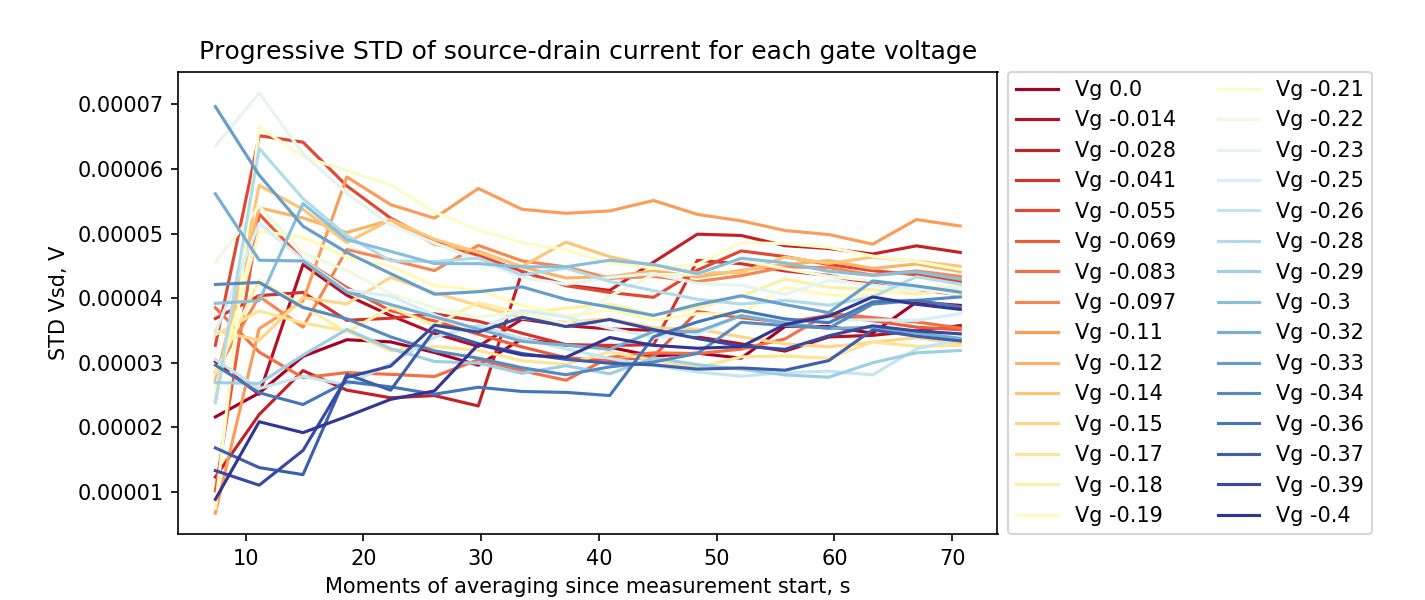

In [15]:
n_averages_vector = np.arange(2, fast_ramp.n_repetitions())
averaging_timestamps = n_averages_vector * fast_ramp.step_duration() * fast_ramp.n_steps()

std_progress = np.empty((fast_ramp.n_repetitions() - 2, fast_ramp.n_steps()))
for end in n_averages_vector:
    std_progress[end - 2, :] = voltages_matrix[:end, :].std(0)
    
fig = plt.figure(figsize=(9.5, 4))

color = iter(cm.rainbow(np.linspace(0, 1, fast_ramp.n_steps())))
c = next(color)

# plots = plt.plot(n_averages_vector, std_progress)
plots = plt.plot(averaging_timestamps, std_progress)

plt.title('Progressive STD of source-drain current for each gate voltage')
# plt.xlabel('Number of averages, #')
plt.xlabel('Moments of averaging since measurement start, s')
plt.ylabel('STD Vsd, V')

for vg, plot in zip(gate_voltage_points, plots):
    i = np.abs(vg) / np.abs(fast_ramp.start_ramp_voltage()-fast_ramp.finish_ramp_voltage())
    plot.set_color(cm.RdYlBu(i))

plt.legend(plots, ["Vg {:.2}".format(i) for i in gate_voltage_points], 
           loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

fig.subplots_adjust(right=0.7)

# Miscellaneous

## A helper measurement that collects MANY samples starting from a trigger
NOT 1 sample PER 1 trigger, BUT N samples starting from 1 trigger

In [16]:
# num_of_sample_to_acquire = int(64*1024/lockin.buffer.bytes_per_sample)
# lockin.buffer.set_capture_rate_to_maximum()

# try:
#     raw_data_all = lockin.buffer.start_capture_at_trigger(
#         num_of_sample_to_acquire,  # number of samples to acquire
#         awg.play  # launches the trigger pulse train
#     )
# finally:
#     awg.stop()

# raw_data = raw_data_all[capture_variable_name]
    
# time_axis = np.arange(len(raw_data)) * 1/lockin.buffer.capture_rate()

# plt.figure()
# plt.plot(time_axis, raw_data, '.-')
# # plt.xlabel('Sample #, S')
# plt.xlabel('Time, s')
# plt.ylabel('Transistor drain current as voltage, V')

In [17]:
# # removeing the (possibly) groun-loop noise oscillations from the signal using savitsky-golay filter ;)

# y = raw_data[capture_variable_name][:300]

# yhat = savgol_filter(y, 25, 1)

# plt.figure()
# plt.plot(y)
# plt.plot(yhat, color='red')
# plt.show()